In [1]:
import pickle
with open('train.pkl','rb') as f:
    data = pickle.load(f)
# data

In [2]:
import numpy as np
from PIL import Image
image_data = []
image_data_transposed = []
for image in data['images']:
    image_data.append(np.array(image))
    image_data_transposed.append(np.array(image).transpose((2, 0, 1))/255.0)
# image_data 

In [3]:
labels = data['labels']
# labels

In [4]:
import PIL
def display_images(images):
        img = Image.fromarray(images)
        display(img.resize((128,128),PIL.Image.LANCZOS))

##  Question1: Display 10 random images from each class

In [5]:
unique_labels = list(set(labels))
label_image_dict = {key:[] for key in unique_labels}

In [6]:
label_image_dict

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [7]:



# for key in unique_labels:
    

In [8]:
labels_arr = np.array(labels)


In [9]:
labels[4936]

0

labels:0


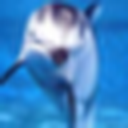

labels:0


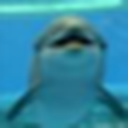

labels:0


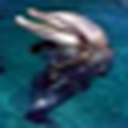

labels:0


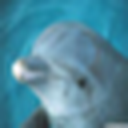

labels:0


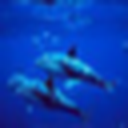

labels:0


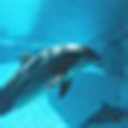

labels:0


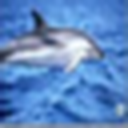

labels:1


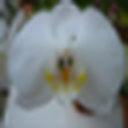

labels:1


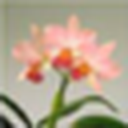

labels:2


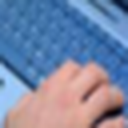

labels:2


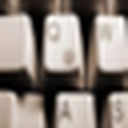

labels:2


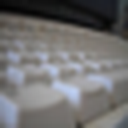

labels:3


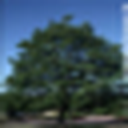

labels:3


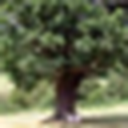

labels:3


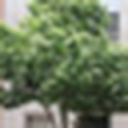

labels:3


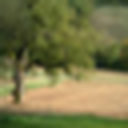

labels:3


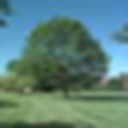

labels:3


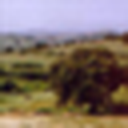

labels:3


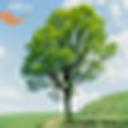

labels:3


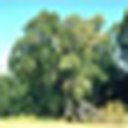

labels:3


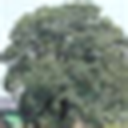

labels:5


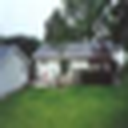

labels:5


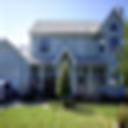

labels:5


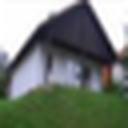

labels:5


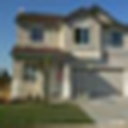

labels:6


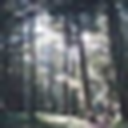

labels:6


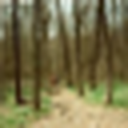

labels:6


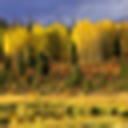

labels:6


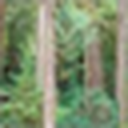

labels:7


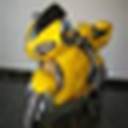

labels:7


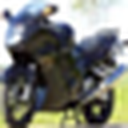

labels:7


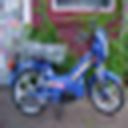

labels:7


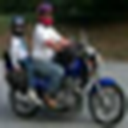

labels:7


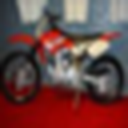

labels:7


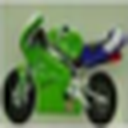

labels:7


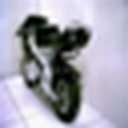

labels:7


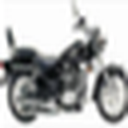

labels:7


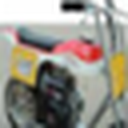

labels:8


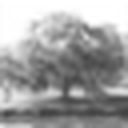

labels:8


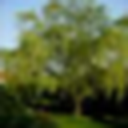

labels:8


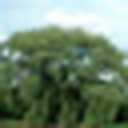

labels:9


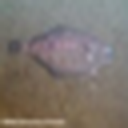

labels:9


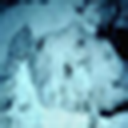

labels:9


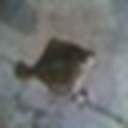

labels:9


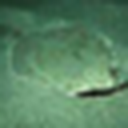

labels:9


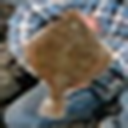

labels:9


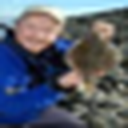

labels:9


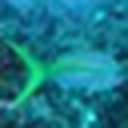

In [10]:
import random
for label in unique_labels:
    indices = np.where(labels_arr==label)[0]
    rand_indices = random.randint(0, 9)
    indices = indices[:rand_indices]
    for index in indices:
        print("labels:{}".format(label))
        display_images(image_data[index])

In [20]:
import torch.nn as nn

class VGG(nn.Module):
    def vgg_conv_layers(self,number_convolutions, input_channels, output_channels):
        conv_layers = []
        for convolutions in range(number_convolutions):
            conv_layers.append(nn.Conv2d(input_channels,output_channels,kernel_size=3,padding=1))
            conv_layers.append(nn.BatchNorm2d(output_channels))
            conv_layers.append(nn.ReLU())
            conv_layers.append(nn.Dropout(0))
            input_channels = output_channels
        conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return conv_layers
        
    def __init__(self, image, architecture):
        super(VGG, self).__init__()
        self.image = image
        self.blocks = []

        input_channels =self.image[0].shape[-1]
        for (number_convolutions, output_channels) in architecture:
            self.blocks.append(nn.Sequential(*self.vgg_conv_layers(number_convolutions, input_channels, output_channels)))
            input_channels = output_channels
#         flattened_size = output_channels*int(self.image[0].shape[0])*int(self.image[0].shape[0])

        flattened_size = output_channels*int(self.image[0].shape[0]/(2**len(architecture)))*int(self.image[0].shape[0]/(2**len(architecture)))
        self.network = nn.Sequential(
            *self.blocks,
            nn.Flatten(),
            nn.Linear(flattened_size, flattened_size),
            nn.ReLU(), 
            nn.Dropout(0.4),
            nn.Linear(flattened_size, flattened_size), 
            nn.ReLU(), 
            nn.Dropout(0.4),
            nn.Linear(flattened_size, 10)
        )
        



    def forward(self, x, print_falg=False):
        if print_falg:
            for layer in self.network:
                x = layer(x)
                print("layer",layer.__class__.__name__,x.size())
            return x
        else:
            return self.network(x)
    

In [21]:
from torch.utils.data import TensorDataset, DataLoader
import torch
tensor_image_data = torch.Tensor(image_data_transposed)
tensor_labels = torch.Tensor(labels_arr)
full_dataset = TensorDataset(tensor_image_data,tensor_labels)
train_size = int(0.85 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
print("Number of train samples",len(train_dataset))
print("Number of test samples", len(test_dataset))
print("Number of validation samples", len(val_dataset))

Number of train samples 3825
Number of test samples 750
Number of validation samples 425


In [23]:
train_dataloader = DataLoader(train_dataset,batch_size=32)
test_dataloader = DataLoader(test_dataset,batch_size=32)
val_dataloader = DataLoader(val_dataset,batch_size=32)

In [77]:
import joblib
joblib.dump(train_dataloader,'train_dataloader')
joblib.dump(test_dataloader,'test_dataloader')
joblib.dump(val_dataloader,'val_dataloader')

['val_dataloader']

In [22]:
import joblib
train_dataloader = joblib.load('train_dataloader')
test_dataloader = joblib.load('test_dataloader')
val_dataloader = joblib.load('val_dataloader')

In [23]:
labels_2 = []
for batch in val_dataloader:
    labels_2.append(batch[1].numpy())
list(set(list(np.concatenate(labels_2))))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [24]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [25]:
# code adapted from a  pytorch repo
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [26]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [27]:
epochs=50

## Training loop

In [28]:
import time
import os
def train(train_dataloader, val_dataloader, model, optimizer, criterion):
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    early_stopping = EarlyStopping(patience=4, verbose=True)

    # For each epoch...
    for epoch_i in range(0, epochs):



        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0
        total_train_accuracy=0


        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 20 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            image = batch[0]
            x = image.cuda()
            y = batch[1].type(torch.long).cuda()
#             print(x,y)
            # print(y)
            # compute forward pass
            model.zero_grad()        

            logits = model.forward(x)
            # if epoch_i==0:
            #   print(logits)

            loss = criterion(logits,y)


            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            # optimizer_euclidean.step()
            optimizer.step()
            # optimizer_euclidean.step()
            # Update the learning rate.
            # scheduler.step()
            logits = logits.detach().cpu().numpy()
            label_ids = y.to('cpu').numpy()
            total_train_accuracy += flat_accuracy(logits, label_ids)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)
        print(" Train Accuracy: {0:.2f}".format(avg_train_accuracy))

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_f1 = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in val_dataloader:


            image = batch[0]
            x = image.cuda()
            y = batch[1].type(torch.long).cuda()
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.

                logits = model.forward(x)            
#             criterion = nn.CrossEntropyLoss()

            loss = criterion(logits,y)


            # Accumulate the validation loss.
            total_eval_loss += loss.item()
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = y.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_f1 += flat_accuracy(logits,label_ids)


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_f1 / len(val_dataloader)
        print("  validation accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(val_dataloader)
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
          print("Early stopping")
          break  
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))
        output_dir = 'model_vgg_net_arch_3/'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)
        torch.save(model.state_dict(), os.path.join(output_dir, 'model_weights_dropout_0'))

#         !rm -rf "model_vgg_net_arch_1"
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))  
    return training_stats

    


In [29]:
def test(test_dataloader, model):
    model.eval()

    predictions , true_labels, ids = [], [], []
    for index,batch in enumerate(test_dataloader):
            image = batch[0]
            x = image.cuda()
            y = batch[1].type(torch.long).cuda()
            with torch.no_grad():
              # Forward pass, calculate logit predictions
                outputs = model.forward(x) 

            logits = outputs
            logits = logits.detach().cpu().numpy()
            label_ids = y.to('cpu').numpy()
            predictions.append(logits)
            true_labels.append(label_ids)
    return predictions, true_labels

## Architecture 3 


In [62]:
vgg_net = VGG(image_data, [(2,16),(2,32), (2,64)])

In [63]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

In [64]:
vgg_net.apply(init_weights)

VGG(
  (network): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0, inplace=False)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [65]:
vgg_net.cuda()

VGG(
  (network): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0, inplace=False)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [66]:
import torch
X = torch.randn(size=(1, 3, 32, 32)).cuda()

vgg_net(X, print_falg=True)

layer Sequential torch.Size([1, 16, 16, 16])
layer Sequential torch.Size([1, 32, 8, 8])
layer Sequential torch.Size([1, 64, 4, 4])
layer Flatten torch.Size([1, 1024])
layer Linear torch.Size([1, 1024])
layer ReLU torch.Size([1, 1024])
layer Dropout torch.Size([1, 1024])
layer Linear torch.Size([1, 1024])
layer ReLU torch.Size([1, 1024])
layer Dropout torch.Size([1, 1024])
layer Linear torch.Size([1, 10])


tensor([[-4.6948, -1.4505, -3.8544,  2.6885, -0.5426,  4.5176,  2.2588, -5.3125,
         -5.1175,  1.0541]], device='cuda:0', grad_fn=<AddmmBackward>)

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vgg_net.parameters(),
                  lr = 1e-3, 
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [68]:
training_stats =train(train_dataloader, val_dataloader, vgg_net,optimizer,criterion)


======== Epoch 1 / 50 ========
Training...
  Batch    20  of    120.    Elapsed: 0:00:00.
  Batch    40  of    120.    Elapsed: 0:00:00.
  Batch    60  of    120.    Elapsed: 0:00:01.
  Batch    80  of    120.    Elapsed: 0:00:01.
  Batch   100  of    120.    Elapsed: 0:00:01.
 Train Accuracy: 0.37

  Average training loss: 2.09
  Training epcoh took: 0:00:01

Running Validation...
  validation accuracy: 0.53
Validation loss decreased (inf --> 1.330518).  Saving model ...
  Validation Loss: 1.33
  Validation took: 0:00:00
Saving model to model_vgg_net_arch_3/

======== Epoch 2 / 50 ========
Training...
  Batch    20  of    120.    Elapsed: 0:00:00.
  Batch    40  of    120.    Elapsed: 0:00:00.
  Batch    60  of    120.    Elapsed: 0:00:01.
  Batch    80  of    120.    Elapsed: 0:00:01.
  Batch   100  of    120.    Elapsed: 0:00:01.
 Train Accuracy: 0.53

  Average training loss: 1.38
  Training epcoh took: 0:00:01

Running Validation...
  validation accuracy: 0.57
Validation loss dec

In [69]:
import pandas as pd

pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.09,1.33,0:00:01,0:00:00
2,1.38,1.20,0:00:01,0:00:00
3,1.20,1.09,0:00:01,0:00:00
4,1.08,1.03,0:00:01,0:00:00
5,0.98,1.04,0:00:01,0:00:00
6,0.89,0.98,0:00:01,0:00:00
7,0.78,0.96,0:00:01,0:00:00
8,0.72,0.96,0:00:01,0:00:00
9,0.67,1.07,0:00:01,0:00:00


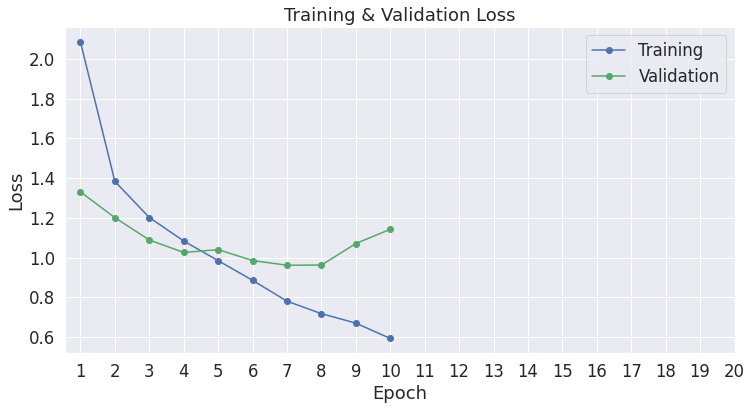

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

plt.show()

In [101]:
# conv layer dropouts 0.2 FC layer dropouts 0.4
vgg_net.load_state_dict(torch.load('model_vgg_net_arch_3/model_weights_dropout_0.2'))

<All keys matched successfully>

In [68]:
# conv layer dropouts 0.5 FC layer dropouts 0.4
vgg_net.load_state_dict(torch.load('model_vgg_net_arch_3/model_weights_dropout_0.5'))

<All keys matched successfully>

In [41]:
# conv layer dropouts 0.7 FC layer dropouts 0.4
vgg_net.load_state_dict(torch.load('model_vgg_net_arch_3/model_weights_dropout_0.7'))

<All keys matched successfully>

In [61]:
# conv layer dropouts 0.3 FC layer dropouts 0.4
vgg_net.load_state_dict(torch.load('model_vgg_net_arch_3/model_weights_dropout_0.3'))

<All keys matched successfully>

In [74]:
# conv layer dropouts 0 FC layer dropouts 0.4
vgg_net.load_state_dict(torch.load('model_vgg_net_arch_3/model_weights_dropout_0'))

<All keys matched successfully>

In [75]:
predictions, true_labels = test(test_dataloader, vgg_net)

In [76]:
flat_predictions = np.concatenate(predictions, axis=0)

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

In [104]:
# conv layer dropouts 0.2 FC layer dropouts 0.4

flat_true_labels = flat_true_labels.flatten()
np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)

0.5693333333333334

In [71]:
# conv layer dropouts 0.5 FC layer dropouts 0.4

flat_true_labels = flat_true_labels.flatten()
np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)

0.23333333333333334

In [44]:
# conv layer dropouts 0.7 FC layer dropouts 0.4
flat_true_labels = flat_true_labels.flatten()
np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)

0.09733333333333333

In [64]:
# conv layer dropouts 0.3 FC layer dropouts 0.4
flat_true_labels = flat_true_labels.flatten()
np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)

0.3293333333333333

In [77]:
# conv layer dropouts 0 FC layer dropouts 0.4
flat_true_labels = flat_true_labels.flatten()
np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)

0.7053333333333334